# MNIST ELM Classifier

Author: **Rafael Ito**  
e-mail: ito.rafael@gmail.com

# 0. Dataset and Description

**Name:**  MNIST  
**Description:** this notebook uses the MNIST database to perform an ELM (extreme learning machine) linear classifier with the aim of image classification of handwritten digits. We use the validation set to choose the hyperparameter alpha, which is the regularization coefficient (rigde regression, norm 2).

# 1. Libraries and packages

## 1.1 Install packages

In [0]:
!pip install -q \
    numpy       \
    sklearn     \
    matplotlib  

## 1.2 Import libraries

In [2]:
#-------------------------------------------------
# general
#-------------------
import numpy as np
import pandas as pd
import scipy.io as sio
#-------------------------------------------------
# scikit-learn
#-------------------
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import zero_one_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report as cr
#-------------------------------------------------
# data visualization
#-------------------
import matplotlib.pyplot as plt
import seaborn as sns
#-------------------------------------------------
# additional config
#-------------------
# random seed generator
np.random.seed(42)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1.3 Check device

In [0]:
# device = torch.device('cpu')
# if torch.cuda.is_available():
#     device = torch.device('cuda')
# print('Device:', device)

## 1.4 Constants definition

In [0]:
# these are the values of alpha (regularization coefficient) that will be used to perform a first search 
#alpha_interval = [2**-10, 2**-8, 2**-6, 2**-4, 2**-2, 2**0, 2**2, 2**4, 2**6, 2**8, 2**10]
alpha_interval = [2**-10, 2**-8, 2**-6, 2**-4, 2**-2, 2**0, 2**2, 2**4, 2**6, 2**8, 2**10, 2**11, 2**12, 2**13]

# 2. Custom functions and classes

## 2.1 Functions

One-hot enconding (inverse transform)

In [0]:
# one-hot encoding
enc = OneHotEncoder()
enc.fit(np.arange(10).reshape(-1,1));

In [0]:
def get_label(one_hot, encoder=enc):
    # the "+1" is because digit 0 is actually class 10
    return (enc.inverse_transform(one_hot.reshape(-1,10)) + 1) % 10

Get number of samples for each class

In [0]:
def samples4classes(label, debug=False):
    count = np.zeros(10, dtype=int)
    for classes in range(10):
        count[classes] = np.count_nonzero(label == classes)
        if(debug):
            print('Samples from class', (classes+1)%10, '=', count[classes])
    return count

Confusion Matrix

In [0]:
def print_confusion_matrix(confusion_matrix, class_names, title=None, normalize=False, cmap=plt.cm.Blues, figsize = (10,7), fontsize=14):
    # normalized or raw CM
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    #----------------------------
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt, cmap=cmap)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    #----------------------------
    # fix matplotlib 3.1.1 bug
    #heatmap.get_ylim() --> (5.5, 0.5)
    #heatmap.set_ylim(6.0, 0)
    #----------------------------
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

Function that calculate the W

In [0]:
def pseudoinverse(phi, y, alpha=0):
    # identity matrix (with first element = 0) used for rigde regression
    I = np.identity(phi.shape[1])
    I[0][0] = 0
    W = np.linalg.inv((phi.T @ phi) + (alpha * I)) @ phi.T @ y
    return W

Calculate weigths, loss and accuracy

In [0]:
def train_and_val(X_train, y_train_oh, X_valid, y_valid_oh, y_valid, alpha):
    # calculate weights
    W = pseudoinverse(X_train, y_train_oh, alpha)   # calculate weights
    #-------------------
    # validation
    y_logits = X_valid @ W
    loss = mean_squared_error(y_valid_oh, y_logits) # calculate MSE
    y_pred = np.argmax(y_logits, axis=1)            # y predicted
    zero_one_error = zero_one_loss(y_valid, y_pred) # calculate zero-one loss
    return loss, zero_one_error

Golden-section one-dimensional search

In [0]:
def find_alpha(X_train, y_train_oh, X_valid, y_valid_oh, y_valid, a, b, d, Je, criterion):
    # a and b: initial interval of uncertainty
    # d: desired final interval size
    # gr: golden ratio = (np.sqrt(5) - 1)/2
    # L (lambda): midpoint used by the algorithm
    # M (mi): midpoint used by the algorithm
    # criterior: accuracy or loss
    #----------------------------
    if criterion == 'accuracy':
        index = 1
    elif criterion == 'loss':
        index = 0
    else:
        raise ValueError("Criterion should be either 'accuracy' or 'loss'")
    #----------------------------
    gr = 0.618
    L = a + (1 - gr)*(b - a)
    M = a + gr*(b - a)
    J_lambda = Je(X_train, y_train_oh, X_valid, y_valid_oh, y_valid, alpha=L)[index]
    J_mi = Je(X_train, y_train_oh, X_valid, y_valid_oh, y_valid, alpha=M)[index]
    #----------------------------
    index_his = [J_lambda, J_mi]
    alpha_his = [L, M]
    #----------------------------
    while ( (abs(a-b)/2) >= d ):
        if (J_lambda > J_mi):
            a = L
            L = M
            M = a + gr*(b - a)
            J_lambda = J_mi
            J_mi = Je(X_train, y_train_oh, X_valid, y_valid_oh, y_valid, alpha=M)[index]
            index_his.append(J_mi)
            alpha_his.append(M)
        else:
            b = M
            M = L
            L = a + (1 - gr)*(b - a)
            J_mi = J_lambda
            J_lambda = Je(X_train, y_train_oh, X_valid, y_valid_oh, y_valid, alpha=L)[index]
            index_his.append(J_lambda)
            alpha_his.append(L)
    alpha = (a + b)/2
    return alpha, alpha_his, index_his

Function to plot heatmap of digits classification

In [0]:
def plot_heatmap(number, path):
    ex = (W_plot[:,number-1].reshape(28,28))                    # get only column for the number
    #sns.heatmap(denorm(ex.T), cmap="viridis")                  # plot the heatmap using seaborn
    plt.matshow(denorm(ex.T))                                   # plot the heatmap using matplotlib
    plt.savefig(path + 'digit_' + str(number) + '.png', dpi=300) # save figure

## 2.2 Classes

Class to denormalize pixels values

In [0]:
class denormalization():
    def __init__(self, base_value):
        self.base_value = base_value
    def __call__(self, norm_values):
        new_values = norm_values*self.base_value
        return new_values.astype(int)      #NumPy
        #return new_values.type(torch.uint8) #PyTorch

In [0]:
denorm = denormalization(255)

# 3. Dataset

## 3.1 Mount dataset

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# root directory
root_dir = '/content/drive/My Drive/Colab Notebooks/IA353A - Redes Neurais (1s2020)/EFC2/Q2/'
# dataset files path
train_path = root_dir + 'data.mat'
test_path = root_dir + 'test.mat'

## 3.2 Read dataset

In [0]:
# read mat files
train = sio.loadmat(train_path)
test  = sio.loadmat(test_path)

In [18]:
# training set
X = train['X']
y_oh = train['S']
#-------------------
# test set
X_test_raw = test['Xt']
y_test_oh = test['St']
#-------------------
print('shape of X:', X.shape)
print('shape of y:', y_oh.shape)
print('#-------------------')
print('shape of X_test:', X_test_raw.shape)
print('shape of y_test:', y_test_oh.shape)

shape of X: (60000, 784)
shape of y: (60000, 10)
#-------------------
shape of X_test: (10000, 784)
shape of y_test: (10000, 10)


## 3.3 Number of samples for earch class

Training set

In [19]:
# Training + Validation set
y_label = get_label(y_oh)
samples4classes(y_label, debug=True);

Samples from class 1 = 5923
Samples from class 2 = 6742
Samples from class 3 = 5958
Samples from class 4 = 6131
Samples from class 5 = 5842
Samples from class 6 = 5421
Samples from class 7 = 5918
Samples from class 8 = 6265
Samples from class 9 = 5851
Samples from class 0 = 5949


Test set

In [20]:
y_test_label = get_label(y_test_oh)
samples4classes(y_test_label, debug=False)

array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])

Training-Validation split

In [21]:
X_train_raw, X_valid_raw, y_train_oh, y_valid_oh = train_test_split(X, y_oh, train_size=0.8)
#-------------------
print(X.shape)
print(X_train_raw.shape)

(60000, 784)
(48000, 784)


In [22]:
print(samples4classes(get_label(y_oh)))
print(samples4classes(get_label(y_valid_oh)))

[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
[1175 1322 1174 1219 1176 1104 1177 1299 1160 1194]


In [0]:
y_valid = enc.inverse_transform(y_valid_oh)
y_train = enc.inverse_transform(y_train_oh)
y_test = enc.inverse_transform(y_test_oh)

Creating "hidden layer" and applying non-linearity

In [24]:
# normal distribution with std dev of 0.2
H = np.random.normal(loc=0.0, scale=0.2, size=(784,500))
print(H.shape)

(784, 500)


In [25]:
# calculate new features after "hidden layer"
X_train_before = X_train_raw @ H
X_valid_before = X_valid_raw @ H
X_test_before = X_test_raw @ H
#-------------------
print(X_train_before.shape)
print(X_valid_before.shape)

(48000, 500)
(12000, 500)


In [26]:
# applying non-linearity (in this case, we are using ReLU)
X_train = np.maximum(0, X_train_before)
X_valid = np.maximum(0, X_valid_before)
X_test = np.maximum(0, X_test_before)
#-------------------
print(X_train_before[0][:6])
print(X_train[0][:6])


[-0.6874434   0.03454662 -0.39138073 -0.94181519 -0.67181528  1.57430642]
[0.         0.03454662 0.         0.         0.         1.57430642]


Inserting bias

In [27]:
phi_X  = np.insert(X_train, 0, [1], axis=1)
phi_Xv = np.insert(X_valid, 0, [1], axis=1)
phi_Xt = np.insert(X_test, 0, [1], axis=1)
#-------------------
print(X_train.shape)
print(phi_X.shape)

(48000, 500)
(48000, 501)


"Training" loop

In [0]:
acc_his = []
loss_his = []
for alpha in alpha_interval:
    loss, zero_one_error = train_and_val(phi_X, y_train_oh, phi_Xv, y_valid_oh, y_valid, alpha)
    loss_his.append(loss)
    acc_his.append(1 - zero_one_error)

# 4. Plot loss and accuracy

In [0]:
# directory path to save figures
path_alpha = root_dir + 'figures/alpha/'

### 4.1 Loss (Mean Squared Error)

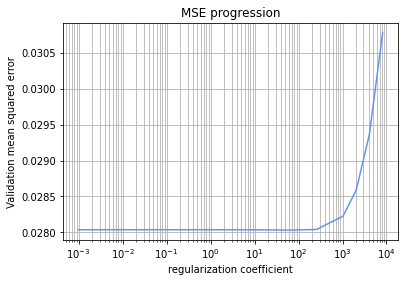

In [30]:
# plot training and validation accuracy
#plt.semilogx(alpha_interval, loss_his, 'o', basex=10, color='blue')
plt.semilogx(alpha_interval, loss_his, basex=10, color='cornflowerblue')
#-------------------------------------------------
# axis label
plt.xlabel('regularization coefficient')
plt.ylabel('Validation mean squared error')
# title
plt.title('MSE progression')
#-------------------------------------------------
#plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True, which='both') # add grid
plt.savefig(path_alpha + 'alpha_MSE_coarse_search.png', dpi=300)
plt.show()

### 4.2 Accuracy

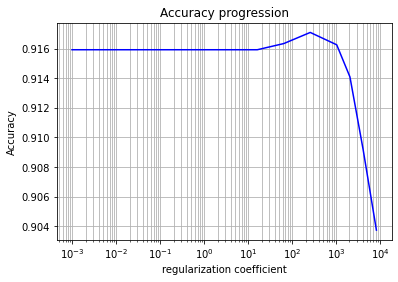

In [31]:
# plot training and validation accuracy
plt.semilogx(alpha_interval, acc_his, basex=10, color='blue')
#-------------------------------------------------
# axis label
plt.xlabel('regularization coefficient')
plt.ylabel('Accuracy')
# title
plt.title('Accuracy progression')
#-------------------------------------------------
#plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True, which='both') # add grid
plt.savefig(path_alpha + 'alpha_ACCURACY_coarse_search.png', dpi=300)
plt.show()

# 5. Fine tuning in alpha

### 5.1 Loss (Mean Squared Error)

In [32]:
min_loss = np.argmin(loss_his)
best_alpha_mse = alpha_interval[min_loss]
print('index for minimum loss:', min_loss)
print('alpha for minimum loss:', best_alpha_mse)

index for minimum loss: 8
alpha for minimum loss: 64


In [33]:
# define interval of search
a = alpha_interval[min_loss - 1]
b = alpha_interval[min_loss + 1]
d = 1e-1
# search for the optimum alpha
mse_alpha_best, mse_alpha_his, mse_alpha_loss = \
    find_alpha(phi_X, y_train_oh, phi_Xv, y_valid_oh, y_valid, a, b, d, Je=train_and_val, criterion='loss')
print('optimum regularization coefficient for best MSE:', mse_alpha_best)

optimum regularization coefficient for best MSE: 102.65191359559469


In [0]:
# ordering alpha history
order_mse = np.argsort(mse_alpha_his)
xs_mse = np.array(mse_alpha_his)[order_mse]
ys_mse = np.array(mse_alpha_loss)[order_mse]

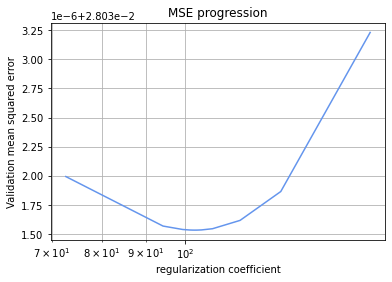

In [35]:
# plot training and validation accuracy
plt.semilogx(xs_mse, ys_mse, basex=10, color='cornflowerblue')
#-------------------------------------------------
# axis label
plt.xlabel('regularization coefficient')
plt.ylabel('Validation mean squared error')
# title
plt.title('MSE progression')
#-------------------------------------------------
#plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True, which='both') # add grid
plt.savefig(path_alpha + 'alpha_MSE_fine_search.png', dpi=300)
plt.show()

### 5.2 Accuracy

In [36]:
max_acc = np.argmax(acc_his)
best_alpha_acc = alpha_interval[max_acc]
print('index for maximum accuracy:', max_acc)
print('alpha for maximum accuracy:', best_alpha_acc)

index for maximum accuracy: 9
alpha for maximum accuracy: 256


In [37]:
# define interval of search
a = alpha_interval[max_acc - 1]
b = alpha_interval[max_acc + 1]
d = 1e-1
# search for the optimum alpha
acc_alpha_best, acc_alpha_his, acc_alpha_acc = \
    find_alpha(phi_X, y_train_oh, phi_Xv, y_valid_oh, y_valid, a, b, d, Je=train_and_val, criterion='accuracy')
print('optimum regularization coefficient for best accuracy:', acc_alpha_best)

optimum regularization coefficient for best accuracy: 662.7290611286521


In [0]:
# ordering alpha history
order_acc = np.argsort(acc_alpha_his)
xs_acc = np.array(acc_alpha_his)[order_acc]
ys_acc = 1 - (np.asarray(acc_alpha_acc))[order_acc]

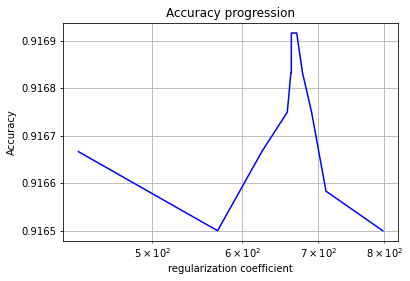

In [39]:
# plot training and validation accuracy
plt.semilogx(xs_acc, ys_acc, basex=10, color='blue')
#-------------------------------------------------
# axis label
plt.xlabel('regularization coefficient')
plt.ylabel('Accuracy')
# title
plt.title('Accuracy progression')
#-------------------------------------------------
#plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True, which='both') # add grid
plt.savefig(path_alpha + 'alpha_ACCURACY_fine_search.png', dpi=300)
plt.show()

## 6. Final "training"

## 6.1 Calculate W with all data (training + validation)

In [40]:
# merge training and validation features
phi_final = np.concatenate((phi_X, phi_Xv), axis=0)
# merge training and validation labels
y_final_oh = np.concatenate((y_train_oh, y_valid_oh), axis=0)
# calculate weights matrix
W_final = pseudoinverse(phi_final, y_final_oh, alpha=acc_alpha_best)
#-------------------
print(W_final.shape)

(501, 10)


Save W matrix in a txt file

In [0]:
# directory path to save W matrix
path_txt = root_dir + 'w118430.txt'
np.savetxt(fname=path_txt, X=W_final, delimiter=', ', newline='\n')

## 6.2 Heatmap

In [0]:
# # delete bias line
# W_plot = np.delete(W_final, 0, axis=0)
# # directory path to save figures
# path_heatmap = root_dir + 'figures/heatmap/'
# #-------------------
# print(W_plot.shape)

In [0]:
# for number in range(10):
#     plot_heatmap(number, path_heatmap)

# 7. Metrics on test set

In [0]:
# calculate labels prediction
y_test_logits = phi_Xt @ W_final
y_pred = (np.argmax(y_test_logits, axis=1) + 1) % 10
# get label of real output
#y_true = enc.inverse_transform(y_test_oh)
y_true = get_label(y_test_oh)

## 7.1 Accuracy, precision and recall

In [0]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

In [46]:
print('Accuracy score = {0:.4f}'.format(acc))
print('Precision score = {0:.4f}'.format(prec))
print('Recall score = {0:.4f}'.format(recall))

Accuracy score = 0.9194
Precision score = 0.9189
Recall score = 0.9184


## 7.2 Confusion Matrix

In [0]:
cm = confusion_matrix(y_true, y_pred)
classes = ['#0', '#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8', '#9']
# directory path to save figures
path_cm = root_dir + 'figures/cm/'

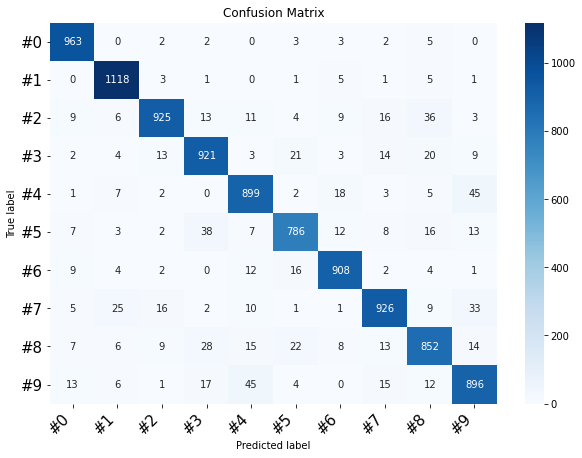

In [48]:
# CM raw
cm_raw = print_confusion_matrix(cm, classes, title='Confusion Matrix', normalize=False, cmap=plt.cm.Blues, fontsize=15, figsize = (10,7))
cm_raw.savefig(path_cm + 'cm_raw', dpi=300, bbox_inches='tight')

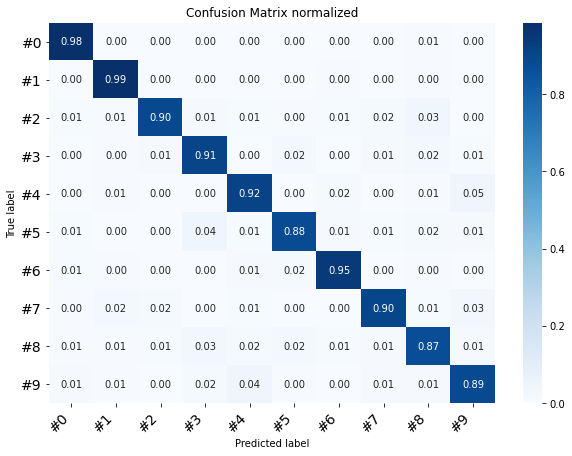

In [49]:
# CM normalized
cm_norm = print_confusion_matrix(cm, classes, title='Confusion Matrix normalized', normalize=True, cmap=plt.cm.Blues, fontsize=14, figsize = (10,7))
cm_norm.savefig(path_cm + 'cm_norm', dpi=300, bbox_inches='tight')

## 7.3 F1-score (macro, micro and weighted)

In [0]:
macro = f1_score(y_true, y_pred, average='macro')
micro = f1_score(y_true, y_pred, average='micro')
weighted = f1_score(y_true, y_pred, average='weighted')

In [51]:
print('F1-score macro = {0:.4f}'.format(macro))
print('F1-score micro = {0:.4f}'.format(micro))
print('F1-score weighted = {0:.4f}'.format(weighted))

F1-score macro = 0.9184
F1-score micro = 0.9194
F1-score weighted = 0.9192


## 8. Plot misclassified numbers

In [0]:
# directory path to save misclassified digits
path_misclassified = root_dir + 'figures/misclassified/'

In [0]:
# get one-dimension y_true
y_true_final = np.squeeze(y_true.reshape(1,-1))
# get index of misclassified digits
misclass_idx = np.nonzero(y_true_final != y_pred)[0]
# create empty array
misclass_array = np.zeros((len(misclass_idx), 10))
diff_array = np.zeros((len(misclass_idx)))
# remove the logits of the real class
for i, index in enumerate(misclass_idx):    
    # array with all logits except the one of the real class
    misclass_array[i] = y_test_logits[index]
    # array with the difference between logits of real and predicted class
    diff_array[i] = np.max(misclass_array[i]) - y_test_logits[index][y_true_final[index]-1]
most_wrong_idx = np.argsort(diff_array)

real class: 4
predicted class: 6
output for class 4: 0.2512
output for class 6: 0.2513


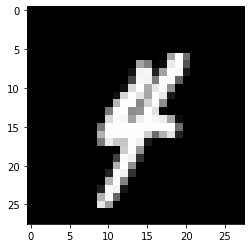

real class: 8
predicted class: 4
output for class 8: 0.1619
output for class 4: 0.9888


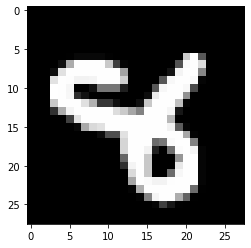

real class: 4
predicted class: 9
output for class 4: 0.1436
output for class 9: 0.9495


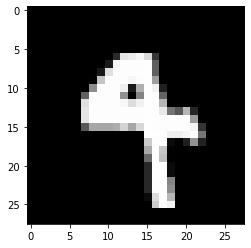

real class: 9
predicted class: 3
output for class 9: -0.1179
output for class 3: 0.6751


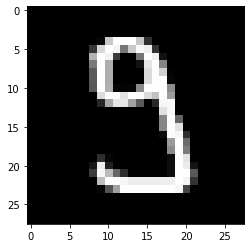

real class: 4
predicted class: 9
output for class 4: 0.1230
output for class 9: 0.8915


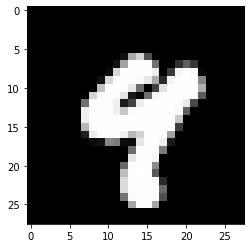

real class: 2
predicted class: 8
output for class 2: 0.0884
output for class 8: 0.8104


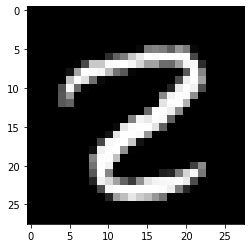

real class: 3
predicted class: 7
output for class 3: 0.1483
output for class 7: 0.8298


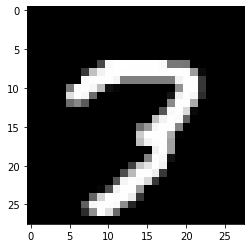

real class: 5
predicted class: 0
output for class 5: -0.0881
output for class 0: 0.5842


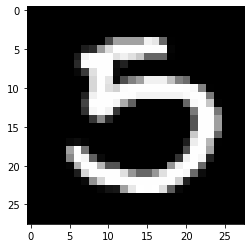

real class: 2
predicted class: 4
output for class 2: 0.0342
output for class 4: 0.6741


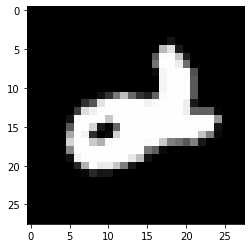

real class: 5
predicted class: 9
output for class 5: 0.3775
output for class 9: 1.0134


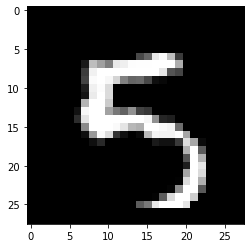

real class: 3
predicted class: 7
output for class 3: 0.0171
output for class 7: 0.6423


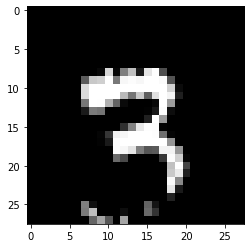

real class: 5
predicted class: 6
output for class 5: -0.0582
output for class 6: 0.5606


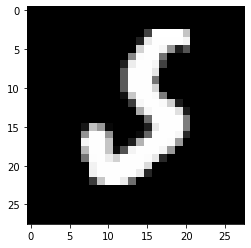

real class: 4
predicted class: 6
output for class 4: 0.0790
output for class 6: 0.6811


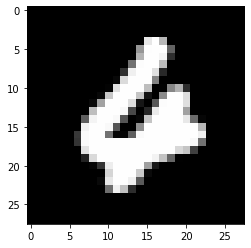

real class: 9
predicted class: 4
output for class 9: -0.1047
output for class 4: 0.4933


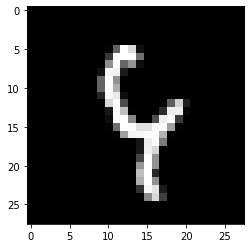

real class: 5
predicted class: 6
output for class 5: -0.0802
output for class 6: 0.5133


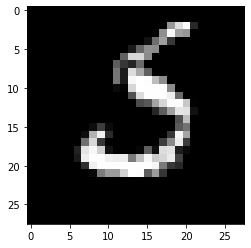

real class: 7
predicted class: 9
output for class 7: -0.0817
output for class 9: 0.5070


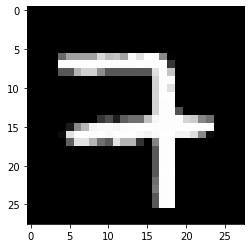

real class: 9
predicted class: 3
output for class 9: -0.0617
output for class 3: 0.5201


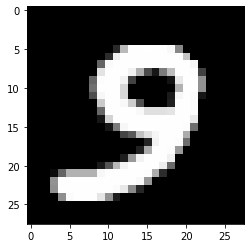

real class: 2
predicted class: 0
output for class 2: 0.1054
output for class 0: 0.6859


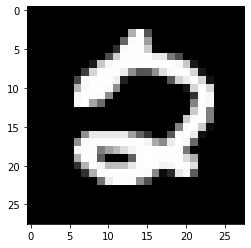

real class: 2
predicted class: 7
output for class 2: 0.0524
output for class 7: 0.6276


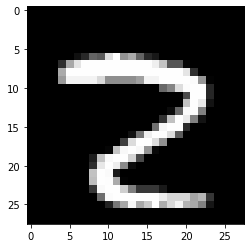

real class: 6
predicted class: 5
output for class 6: 0.0162
output for class 5: 0.5902


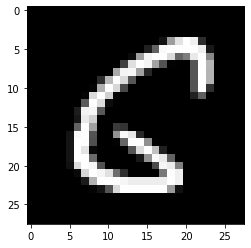

real class: 2
predicted class: 0
output for class 2: 0.1143
output for class 0: 0.6871


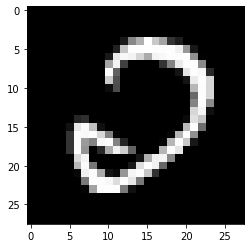

real class: 8
predicted class: 3
output for class 8: 0.0670
output for class 3: 0.6346


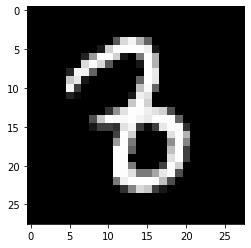

real class: 8
predicted class: 7
output for class 8: 0.0713
output for class 7: 0.6317


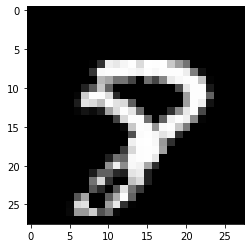

real class: 9
predicted class: 3
output for class 9: 0.0149
output for class 3: 0.5732


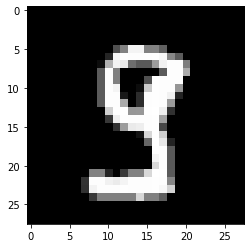

real class: 1
predicted class: 3
output for class 1: 0.0298
output for class 3: 0.5772


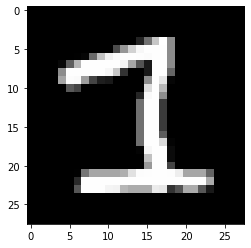

real class: 4
predicted class: 9
output for class 4: 0.0571
output for class 9: 0.6041


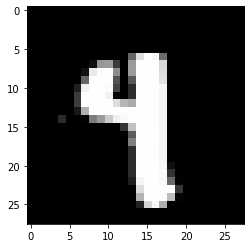

real class: 2
predicted class: 6
output for class 2: -0.0963
output for class 6: 0.4445


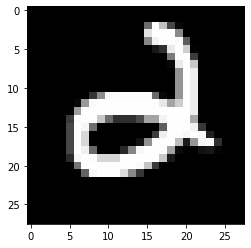

real class: 4
predicted class: 9
output for class 4: 0.1967
output for class 9: 0.7305


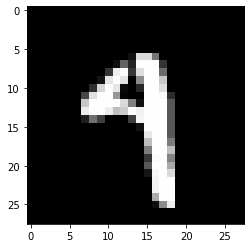

real class: 3
predicted class: 9
output for class 3: -0.1477
output for class 9: 0.3825


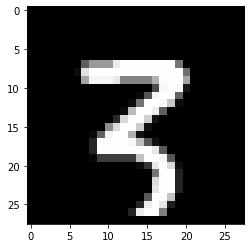

real class: 7
predicted class: 2
output for class 7: 0.0689
output for class 2: 0.5985


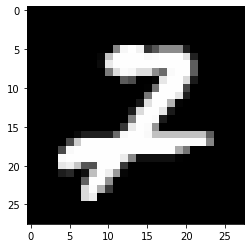

In [54]:
for i in range(30):
    index = misclass_idx[most_wrong_idx[-i]]
    #index = misclass_idx[3]
    print('real class:', y_true_final[index])
    print('predicted class:', y_pred[index])
    print('output for class ', str(y_true_final[index]), ': ', '{0:.4f}'.format(y_test_logits[index][y_true_final[index]-1]), sep='')
    print('output for class ', str(y_pred[index]), ': ', '{0:.4f}'.format(y_test_logits[index][y_pred[index]-1]), sep='')
    data = X_test_raw[index].reshape(28,28).T
    #plt.imshow(data, interpolation='nearest')
    plt.imshow(data, cmap='Greys_r')
    plt.savefig(path_misclassified + str(i) + '.png', dpi=300)
    plt.show()

# End of the notebook